In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly.express as px

from plotly import graph_objects as go

import sys
sys.path.append("..")

flatten = lambda t: [item for sublist in t for item in sublist]

In [2]:
comment_df = pd.read_excel("..\data\cleaned_swed_stemmed.xlsx")
comment_df.drop(index = [9, 1555, 2474, 2483, 4346, 7212], inplace = True)

# TF-IDF

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer()

In [4]:
term_doc = pd.DataFrame(c.fit_transform(comment_df.text.astype('U')).toarray())
#term_doc = pd.get_dummies(comment_df.text)

term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8584    1.0
8585    1.0
8586    1.0
8587    1.0
8588    1.0
Length: 8589, dtype: float64

In [5]:
# idf number of documents / number of documents containing the word
temp = np.zeros(len(term_doc.columns))

for i in range(len(temp)):
    temp[i] = sum(term_doc.iloc[:,i].map(lambda x: 1 if x > 0 else 0))
    
idf = np.log(len(term_doc) / temp)

In [ ]:
tf_idf = term_frequency * idf


In [ ]:
#LSA method: making SVD with the tf_idf, then taking the first n most significant vectors to score the documents

from sklearn.decomposition import TruncatedSVD
n_comp = 7
svd = TruncatedSVD(n_components = n_comp)
lsa = svd.fit_transform(tf_idf)

In [ ]:
topic_encoded_df = pd.DataFrame(lsa, index = comment_df.index,
                                columns = [f"topic{i}" for i in range(n_comp)])
topic_encoded_df["text"] = comment_df.text

In [ ]:
encoding_matrix = pd.DataFrame(svd.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = c.get_feature_names())


C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
top_by_topic = pd.DataFrame()
for col in encoding_matrix.index:
    topic_temp_df = pd.DataFrame(encoding_matrix.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df.columns = [col, col+"_value"]
    top_by_topic = pd.concat([top_by_topic, topic_temp_df], axis = 1)

In [ ]:
top_by_topic.to_excel(r"..\data\top_by_topic_LSI01.xlsx")
top_by_topic

,topic0,topic0_value,topic1,topic1_value,topic2,topic2_value,topic3,topic3_value,topic4,topic4_value,topic5,topic5_value,topic6,topic6_value
0,mzp,0.241040,átlépted,0.306265,gyurcsány,0.617077,poll,0.714639,dobrev,0.482452,szavaz,0.582955,tóth,0.465786
1,szavaz,0.231386,korlátot,0.305372,stop,0.399565,peter,0.552378,mzp,0.348461,online,0.315262,csaba,0.454294
2,tud,0.208215,végrehajt,0.297741,karácsony,0.306529,tamad,0.147880,gyurcsány,-0.308558,orbán,-0.205563,dobrev,-0.294315
3,dobrev,0.207115,napi,0.293080,szavaz,-0.226961,cimbe,0.147880,karácsony,0.199096,stop,0.200247,karácsony,0.287204
4,fog,0.203384,poszt,0.292869,online,-0.125764,tegyel,0.141450,stop,-0.181668,tud,-0.185917,fidesz,-0.263305
5,karácsony,0.187535,próbál,0.278108,tud,-0.120292,ujra,0.131235,tud,-0.164943,perc,0.132953,gyurcsány,-0.214438
6,fidesz,0.181785,intézkedés,0.271950,mzp,0.109944,reportol,0.117841,klára,0.147019,megy,0.131997,tud,0.134833
7,gyurcsány,0.157537,töröltük,0.263689,átlépted,0.096237,dobrev,0.088435,ember,-0.140156,karácsony,0.120163,mzp,0.131747
8,mond,0.137771,posztodat,0.263689,korlátot,0.095596,vegzetes,0.075104,nyer,0.138061,gyurcsány,0.115909,klára,-0.126911
9,nyer,0.137081,automatikus,0.263583,megy,-0.094318,figyelmes,0.073645,poll,-0.116053,dobrevre,0.114685,stop,0.105983


In [ ]:
#health check: check which elements are none
comment_df.reset_index().drop(columns = ["index"])[term_frequency.isna().T.any()].index

Int64Index([], dtype='int64')

(1.0, 60.0)

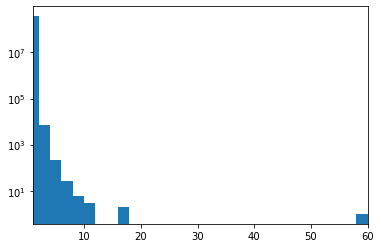

In [ ]:
#health check
plt.hist(c.fit_transform(comment_df.text).toarray().flatten(), bins = 30)
plt.yscale("log")
plt.xlim(1,60)